In [1]:
%matplotlib inline
from __future__ import print_function

import rospy
import rosbag
import itertools
from  tqdm import tqdm
from geometry_msgs.msg import PoseWithCovarianceStamped
import tf
import numpy as np
import time

import matplotlib.pyplot as plt
import os

%load_ext autoreload
%autoreload 2

# Create ground truth

In [2]:
def create_gt(map_name):
    gt_bag_filename = '{0:s}/{1:s}/rosbag/{1:s}_pointcloud_odom_gt.bag'.format(root_folder,map_name)
    if not os.path.isfile(gt_bag_filename):
        gt_bag_filename = '{0:s}/{1:s}/rosbag/{1:s}_pointcloud_gt.bag'.format(root_folder,map_name)
    if not os.path.isfile(gt_bag_filename):
        print('[Error] _gt.bag not found')
        return None

    #gt_bag_filename = '{0:s}/{1:s}/{1:s}_pointcloud_odom_gt.bag'.format(root_folder,map_name)
    #sensors_bag_filename = '{0:s}/{1:s}/{1:s}_sensors.bag'.format(root_folder,map_name)

    #odom_tf_bag_filename = '/tmp/odom_tf.bag'
    #odom_nav_bag_filename = '/tmp/odom_msg.bag'
    print('Reading {:60s}'.format(gt_bag_filename),end='')
    try: 
        gt_bag = rosbag.Bag(gt_bag_filename)
    except:
        gt_bag = rosbag.Bag(gt_bag_filename2)
    print('\t Done')
    time.sleep(0.2)
    
    t_offset = None

    Pose = list()
    for topic, msg, t in tqdm(gt_bag.read_messages(topics=['/carto_pose',])):
    #for topic, msg, t in bag.read_messages(topics=['/amcl_pose',]):
        #yaw angle
        rpy = tf.transformations.euler_from_quaternion((msg.pose.pose.orientation.x,
                                                        msg.pose.pose.orientation.y,
                                                        msg.pose.pose.orientation.z,
                                                        msg.pose.pose.orientation.w,
                                                        'xyzs'))
        if t_offset is None: t_offset = msg.header.stamp.secs - 300 # -5 minutes
        ti = msg.header.stamp.secs-t_offset + 1e-9*msg.header.stamp.nsecs
        Pose.append([ti,
                    msg.pose.pose.position.x,
                    msg.pose.pose.position.y,
                    np.cos(rpy[2]),
                    np.sin(rpy[2])])

    Pose = np.asarray(Pose)

    # Smooth traj
    eps_time = 1e-2#1e-2 #0.01
    del_sum = 0

    while(True):
        Diff = list()
        del_ind = list()
        min_time_jump = 1000
        for i in range(1,len(Pose)):
            dif = Pose[i,0]-Pose[i-1,0]
            Diff.append(dif)
            if dif < min_time_jump: min_time_jump = dif
            if dif <= eps_time: 
                del_ind.append(i)
                del_sum+=1;

    #    time_pose = np.delete(time_pose,del_ind)
        Pose = np.delete(Pose,del_ind,axis=0)
        print(min_time_jump)
        if (len(del_ind)==0): break
    
    return Pose, t_offset

# Extract Wifi data

In [3]:
import rosbag
import tf
import numpy as np
import pandas as pd

from rf_msgs.msg import Rss
"""
load all rss info from rosbag
"""

def get_wifi(map_name,Pose,t_offset,macdict=None,reverse_macdict=None):

    sensors_bag_filename = '{0:s}/{1:s}/rosbag/{1:s}_sensors.bag'.format(root_folder,map_name)
    print('Reading {:60s}'.format(sensors_bag_filename),end='')
    sensors_bag = rosbag.Bag(sensors_bag_filename)
    print('\t Done')

    
    if macdict is None: 
        print('No macdict')
        macdict = {}
        reverse_macdict = {}
        update_macdict = True
    else:
        print('Using macdict')
        update_macdict = False

    sensors_topics = ['/rss{:d}'.format(i) for i in range(1,9)]
    print('Topics: ',sensors_topics)

    sensors_bag = rosbag.Bag(sensors_bag_filename)
    sensors = {topic:list() for topic in sensors_topics}

    Ti,X,Y,Yaw,Topic,Mac,Freq,Data = [list() for i in range(8)]

    for topic, msg, t in tqdm(sensors_bag.read_messages(topics=sensors_topics)):
        ti = msg.header.stamp.secs-t_offset + 1e-9*msg.header.stamp.nsecs
        # interpolate pose
        yaw_c = np.interp(ti,Pose[:,0],Pose[:,3])
        yaw_s = np.interp(ti,Pose[:,0],Pose[:,4])
        try:
            macindex = macdict[msg.mac_address]
        except:
            if update_macdict:
                macindex = int(len(macdict))
                macdict[msg.mac_address] = macindex
                reverse_macdict[macindex] = msg.mac_address
            else:
                macindex = -1
                continue


        # add datapoint
        Ti.append(ti)
        X.append(np.interp(ti,Pose[:,0],Pose[:,1]))
        Y.append(np.interp(ti,Pose[:,0],Pose[:,2]))
        Yaw.append(np.arctan2(yaw_s,yaw_c))
        Topic.append(topic)
        Mac.append(macindex)
        Freq.append(int(msg.freq))
        Data.append(msg.data[0]/95.+1)
    
    return  pd.DataFrame.from_dict({
            'time':Ti,
            'x':X,
            'y':Y,
            'yaw':Yaw,
            'topic':Topic,
            'mac_address':Mac,
            'freq':Freq,
            'data':Data
            }), macdict, reverse_macdict

def filter_wifi(df):
    # create time-slices
    ts = 1
    time_slices = np.arange(df["time"].min(),df["time"].max(),ts)
    tmp = df.groupby(pd.cut(df["time"],time_slices))

    df_list_tmp = [group for name, group in tmp]
    df_list = list()
    for di in df_list_tmp:
        if len(di)>0: df_list.append(di)
            
    # distance filter
    d_thr = 0.5 # merge if less than 50cm
    Dxy = list()
    i = 0
    for c in tqdm(range(len(df_list))):
        dxy = (df_list[i]['x'].max()-df_list[i]['x'].min())**2+(df_list[i]['y'].max()-df_list[i]['y'].min())**2
        if dxy < d_thr**2:
            try:
                df_list[i] = pd.concat([df_list[i],df_list.pop(i+1)])
            except:
                pass
        else:
            i +=1
            Dxy.append(dxy**.5)

    print(len(df_list))
    return df_list


def create_wifi_dataset(df_list,macdict,reverse_macdict):
    XY = np.asarray([[df['x'].mean(), df['y'].mean()] for df in df_list])
    Wifi = np.zeros((XY.shape[0],len(macdict)))
    for xi,df in enumerate(df_list):
        for macindex, data in df.groupby(['mac_address'])['data'].mean().iteritems():
            Wifi[xi,macindex] = data
    print(Wifi.shape)
    
    # delete AP that appear less than x points
    ncounts = np.zeros(Wifi.shape[1])
    for i,wifi in enumerate(Wifi.T):
        ncounts[i] = np.count_nonzero(wifi)
    nthr = 5
    time.sleep(0.2)
    print('APs with more than {:d} points: {:d}'.format(nthr,np.sum(ncounts > nthr)))
    
    filtered_dict = {}
    del_id = list()

    for i,nc in enumerate(ncounts):
        if nc > 5: # if more than 5 occurrences. the ap is saved
            new_index = len(filtered_dict)
            filtered_dict[reverse_macdict[i]] = new_index

    print(len(macdict),'->',len(filtered_dict))
    if len(macdict) != len(filtered_dict): macdict = filtered_dict
    return XY,Wifi,macdict

# Example use


####################
  map: udai-01 
####################
Reading /mnt/matrix/rosbag/processed_data/nict/udai-01/rosbag/udai-01_pointcloud_odom_gt.bag	 Done


7666it [00:00, 20854.75it/s]


0.002025550000325893
0.9940555800003494
Pose: 4681
>> Get Wifi
Reading /mnt/matrix/rosbag/processed_data/nict/udai-01/rosbag/udai-01_sensors.bag	 Done
No macdict
Topics:  ['/rss1', '/rss2', '/rss3', '/rss4', '/rss5', '/rss6', '/rss7', '/rss8']


826254it [00:51, 15900.05it/s]


>> Filter time/distance


100%|██████████| 4829/4829 [00:03<00:00, 1293.55it/s]


2288
>> Filter mac
(2288, 343)
APs with more than 5 points: 270
343 -> 270
>> Recompute Wifi
Reading /mnt/matrix/rosbag/processed_data/nict/udai-01/rosbag/udai-01_sensors.bag	 Done
Using macdict
Topics:  ['/rss1', '/rss2', '/rss3', '/rss4', '/rss5', '/rss6', '/rss7', '/rss8']


826254it [00:45, 18012.49it/s]


>> Re-Filter time/distance


100%|██████████| 4829/4829 [00:03<00:00, 1293.39it/s]


2288
>> Compute Wifi dataset
(2288, 270)
APs with more than 5 points: 270
270 -> 270
Wifi  :  (2288, 270) 
XY    :  (2288, 2)


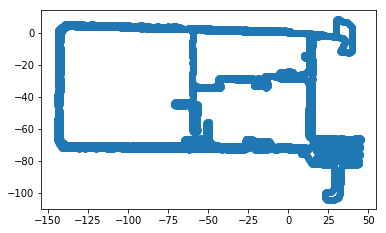

In [4]:
root_folder = '/mnt/matrix/rosbag/processed_data/nict'
map_name = 'udai-01'

print('\n####################\n  map: {:s} \n####################'.format(map_name)); time.sleep(0.2)
Pose, t_offset = create_gt(map_name)
print('Pose: {:d}'.format(int(Pose.shape[0])))
print('>> Get Wifi'); time.sleep(0.2)
df, macdict, reverse_macdict = get_wifi(map_name,Pose,t_offset,macdict=None)
print('>> Filter time/distance'); time.sleep(0.2)
df_list = filter_wifi(df)
print('>> Filter mac'); time.sleep(0.2)
_,_,macdict = create_wifi_dataset(df_list,macdict,reverse_macdict)
#recompute using filtered macdict
print('>> Recompute Wifi'); time.sleep(0.2)
df, macdict, reverse_macdict = get_wifi(map_name,Pose,t_offset,macdict=macdict,reverse_macdict=reverse_macdict)
print('>> Re-Filter time/distance'); time.sleep(0.2)
df_list = filter_wifi(df)
print('>> Compute Wifi dataset'); time.sleep(0.2)
XY,Wifi,macdict = create_wifi_dataset(df_list,macdict,reverse_macdict)

print('Wifi  : ',Wifi.shape,
      '\nXY    : ',XY.shape)
f,ax = plt.subplots()
ax.scatter(XY[:,0],XY[:,1])
ax.set_aspect('equal')

# Save data
#try:
#    os.mkdir('{0:s}/{1:s}/invisible-maps/'.format(root_folder,map_name))
#except:
#    pass
#save_filename = '{0:s}/{1:s}/invisible-maps/{1:s}_WifiData.npz'.format(root_folder,map_name)
#np.savez_compressed(save_filename,XY=XY,Wifi=Wifi,macdict=macdict)